# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [2]:
import pandas as pd
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import string
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("[\w']+")
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('lyrics.csv')

In [7]:
df['tokenized'] = df.apply(lambda row: tokenizer.tokenize(str(row['lyrics'])), axis=1)
# df['lyrics']

In [8]:
df["tokenized_l"] = df["tokenized"].apply(lambda v: list(map(lambda x: x.lower(), v)))

In [9]:
import string
table = str.maketrans({key: None for key in string.punctuation})
def remove_punctuation(x):
    return x.translate(table)
df['tokenized_lp'] = df['tokenized_l'].apply(lambda v: list(map(remove_punctuation, v)))

In [10]:
stop_words = set(map(remove_punctuation, stop_words))
stop_words.add('im')

def remove_stopwords(words):
    return [w for w in words if not w in stop_words] 
        
df['no_stopwords'] = df['tokenized_lp'].apply(lambda v: remove_stopwords(v))

In [11]:
def switch_numeric(words):
    return [w if not w.isnumeric() else 'NUMBER' for w in words]

df['no_stopwords_no_numbers'] = df['no_stopwords'].apply(lambda v: switch_numeric(v))

In [12]:
freqs = df['no_stopwords_no_numbers'].explode().value_counts(normalize=True).to_frame('freq')

In [13]:
# freqs.iloc[:20]
# 
# df['no_stopwords_final'] = df['no_stopwords_no_numbers'].apply(lambda v: remove_stopwords(v))
# freqs = df['no_stopwords_final'].explode().value_counts(normalize=True).to_frame('freq')

In [14]:

frequent_words = set(freqs[freqs['freq'] > freqs['freq'].quantile(q=0.95)].index)
(frequent_words.remove(''))

In [15]:
EMBEDDING_SIZE = 100

In [16]:
# frequent_words = set(freqs[freqs['freq'] > freqs['freq'].quantile(q=0.96)].index)
def remove_non_frequent(words):
    return [w for w in words if w in frequent_words] 

df['final_words'] = df['no_stopwords_no_numbers'].apply(lambda v: remove_non_frequent(v))

# model = Word2Vec(df['final_words'], size=EMBEDDING_SIZE, window=3, min_count=1, workers=8)
# model.save("word2vec.model")


In [3]:
# df = df.sample(frac=1).reset_index(drop=True)

# df.to_pickle("df.pkl")

df = pd.read_pickle("df.pkl")

model = Word2Vec.load("word2vec.model")


### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [18]:
model.wv.similar_by_word('friend')

[('friends', 0.7329444289207458),
 ('lover', 0.7007007002830505),
 ('mine', 0.6148495078086853),
 ('best', 0.5769045352935791),
 ('girlfriend', 0.5347352027893066),
 ('companion', 0.5265414118766785),
 ('depend', 0.5223906636238098),
 ('brother', 0.521097719669342),
 ('pretend', 0.5187185406684875),
 ('always', 0.5175248384475708)]

In [19]:
model.wv.similar_by_word('fly')

[('flying', 0.6655927896499634),
 ('flyin', 0.6134728789329529),
 ('float', 0.6007909774780273),
 ('flown', 0.5840531587600708),
 ('eagles', 0.5678684711456299),
 ('high', 0.567510187625885),
 ('soar', 0.5672122836112976),
 ('wings', 0.5620856285095215),
 ('ride', 0.5557847023010254),
 ('bird', 0.5420757532119751)]

In [20]:
model.wv.similar_by_word('NUMBER')

[('1st', 0.6522047519683838),
 ('2nd', 0.6292223930358887),
 ('sadat', 0.6061900854110718),
 ('fabolous', 0.5914676785469055),
 ('verse', 0.5718549489974976),
 ('3rd', 0.5595517158508301),
 ('three', 0.5545392036437988),
 ('ferg', 0.5376378297805786),
 ('six', 0.5316325426101685),
 ('x', 0.529700517654419)]

In [21]:
model.wv.similar_by_word('easy')

[('hard', 0.6606412529945374),
 ('easier', 0.5876562595367432),
 ('way', 0.5702636241912842),
 ('supposed', 0.5447270274162292),
 ('try', 0.5387265086174011),
 ('cause', 0.5205551385879517),
 ('believe', 0.50733482837677),
 ('sometimes', 0.49786123633384705),
 ('sure', 0.4902315139770508),
 ('life', 0.4879237413406372)]

### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [22]:
import numpy as np

# doctor for man is similar to nurse for woman (racial bias as well)
print(model.wv.similar_by_vector(model.wv['woman'] + model.wv['nurse'] - model.wv['man'], 4))
# running + shoes = walking + boots
print(model.wv.similar_by_vector(model.wv['running'] + model.wv['shoes'] - model.wv['walking'] , 6))

[('nurse', 0.743979811668396), ('woman', 0.5961484313011169), ('doctor', 0.4894254207611084), ('husband', 0.4654938876628876)]
[('shoes', 0.7174487709999084), ('socks', 0.5123054385185242), ('clothes', 0.5078741908073425), ('heels', 0.5052093863487244), ('boots', 0.4752254784107208), ('shirt', 0.47169578075408936)]


In [23]:

print('cosine distance between man and doctor', model.wv.distance('man', 'doctor'))
print('cosine distance between woman and nurse', model.wv.distance('woman', 'nurse'))

print('euclidean distance between man and doctor', np.linalg.norm(model.wv['man'] - model.wv['doctor']))
print('cosine distance between woman and nurse', np.linalg.norm(model.wv['woman'] - model.wv['nurse']))

cosine distance between man and doctor 0.7146157026290894
cosine distance between woman and nurse 0.7047650218009949
euclidean distance between man and doctor 11.51116
cosine distance between woman and nurse 10.800777


## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [24]:
# tweets = pd.read_csv('SCL-OPP/SCL-OPP.txt',names=['tweet', 'polarity', 'structure', 'idx'], sep='\t')
lex = pd.read_csv('SemEval2015-English-Twitter-Lexicon/SemEval2015-English-Twitter-Lexicon.txt',names=['polarity', 'word'], sep='\t')
lex['wv'] = lex['word'].apply(lambda w: model.wv[w] if w in frequent_words else None)


In [25]:
lex = lex.dropna()
len(lex)

732

In [26]:
X = np.matrix(lex['wv'].tolist())
Y = lex['polarity'].values.tolist()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.1, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)
test_mse = mean_squared_error(y_test, clf.predict(X_test))
train_mse = mean_squared_error(y_train, clf.predict(X_train))
print("Test MSE: %.4f" % test_mse)
print("Train MSE: %.4f" % train_mse)

Test MSE: 0.1555
Train MSE: 0.0037


Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [28]:
words_with_sentiments = set(lex['word'].values)
i = 0
for word in frequent_words:
    i += 1
#     set(lex['word'].values)
    if word not in words_with_sentiments:
#         print(model.wv[word].reshape(-1,1))
        pred = clf.predict(model.wv[word].reshape(1,-1))
        if np.abs(pred) > 0.65:
            print(word, pred)

agony [-0.73271985]
dearest [0.65690037]
rabid [-0.86491806]
corrupt [-0.67165121]
infest [-0.84260824]
hunted [-0.66801683]
plague [-0.68505812]
shinning [0.68855735]
slaughtered [-0.83789548]
feeble [-0.8248682]
shined [0.68050903]
thankful [0.7103242]
distorted [-0.67851141]
subsides [-0.79423582]
unleashed [-0.72290935]
numbing [-0.73316332]
present [0.6932092]
decapitated [-0.82751333]
plagues [-0.78344098]
unconscious [-0.72486254]
gab [0.68004761]
deprived [-0.70864838]
writhing [-0.93106882]
inflict [-0.67397058]
mindless [-0.6930827]
stricken [-0.76800199]
vortex [-0.65550466]
choking [-0.69584338]
destroys [-0.72334486]
decayed [-0.75326929]
strangled [-0.83379602]
desecrate [-0.78824691]
writhe [-0.74818537]
breeds [-0.7449691]
labyrinth [-0.76104677]
incest [-0.69672239]
positively [0.69215393]
futile [-0.74814973]
engulfed [-0.86188542]
tormented [-0.76081805]
diseased [-0.6566253]
pleasures [0.75005896]
sleighing [0.65175172]
brighten [0.74242467]
defenseless [-0.67566899

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [29]:
X1 = np.zeros((len(df), len(frequent_words)))
Y1 = df['genre'].values
indices = {k:v for v,k in enumerate(frequent_words)}

for i, doc in enumerate(df['final_words']):
    for word in doc:
        if word in frequent_words:
            X1[i, indices[word]] += 1

In [30]:
# X_train, X_test, y_train, y_test = train_test_split(X1, Y1, random_state=1)
X1_train = X1[:300000]
Y1_train = Y1[:300000]
X1_test = X1[300000:]
Y1_test = Y1[300000:]

clf = MultinomialNB()
clf.fit(X1_train, Y1_train)
Y1_pred = clf.predict(X1_test)

Show the confusion matrix.

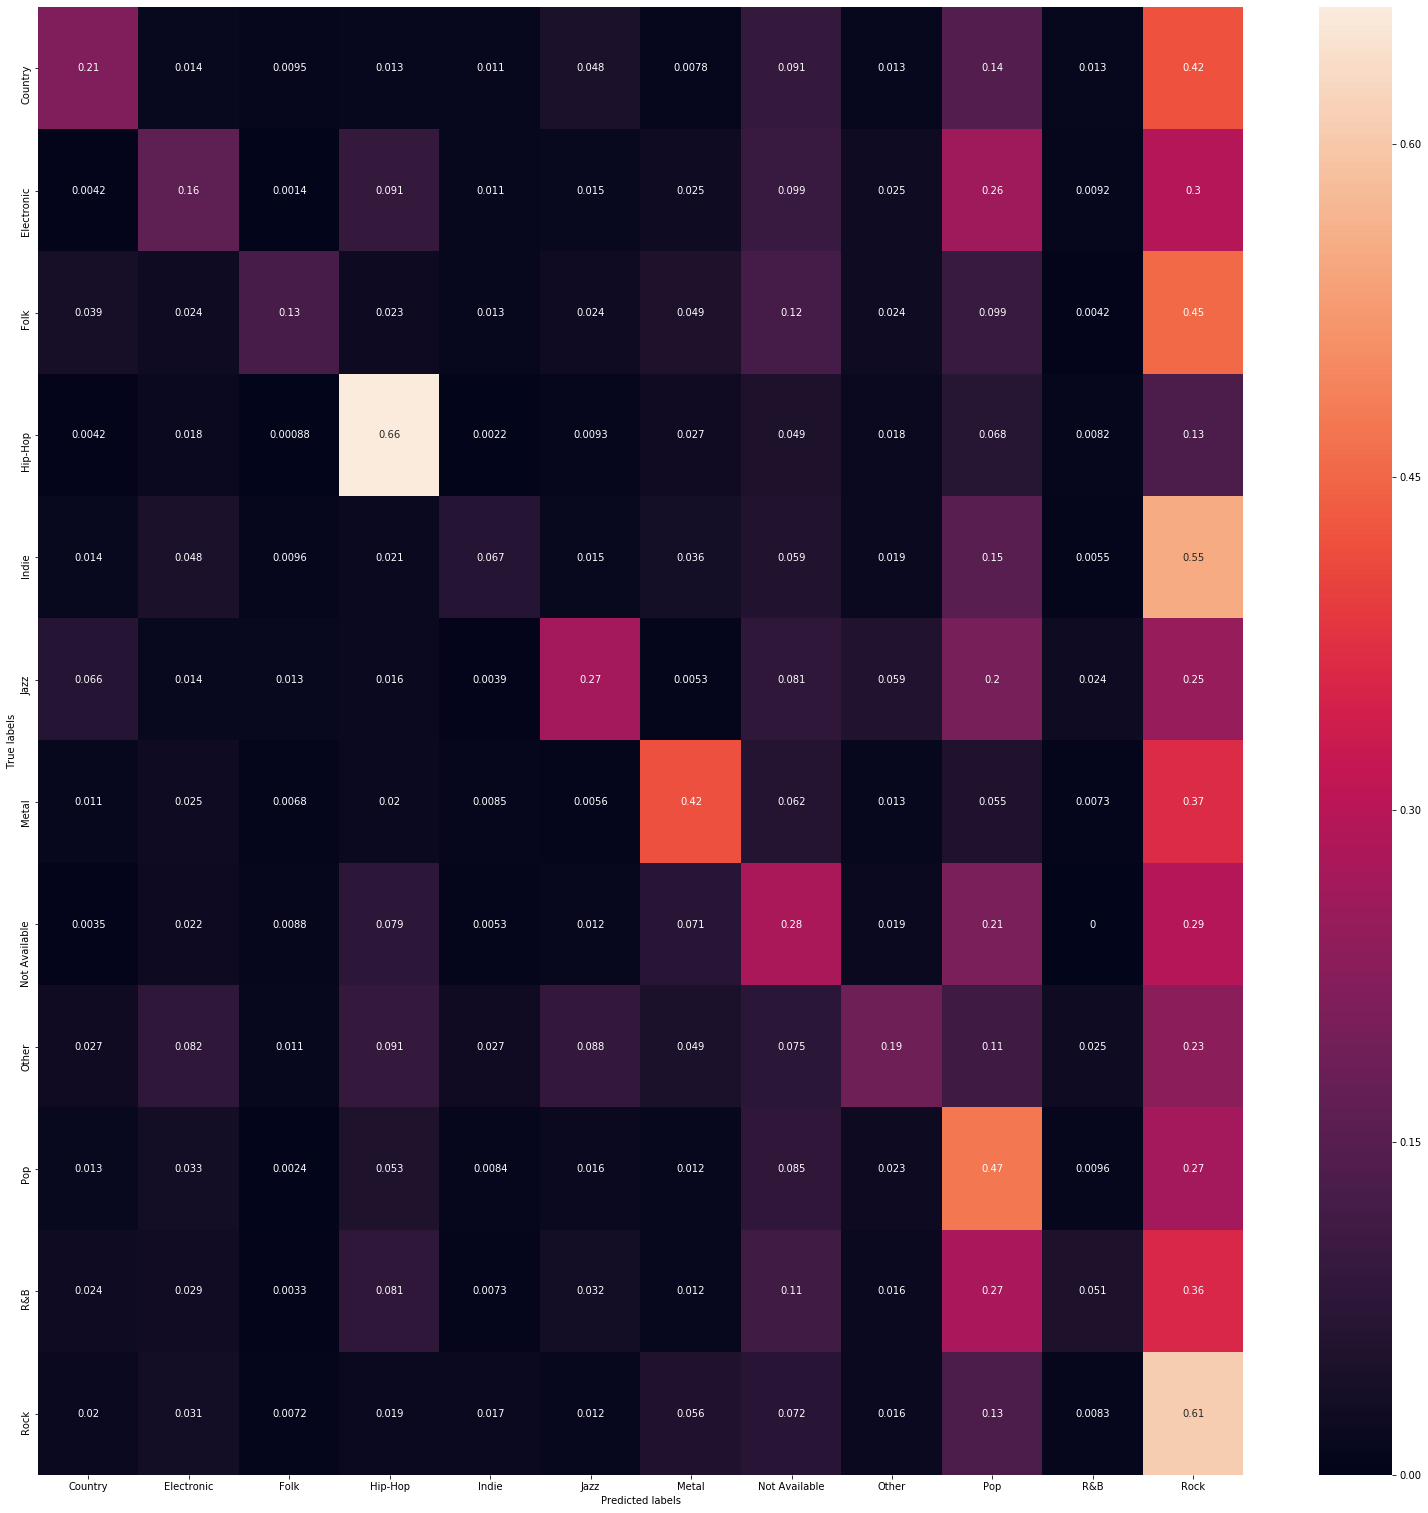

In [31]:


plt.figure(figsize=(27, 27))
cm = confusion_matrix(Y1_pred, Y1_test)

cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True) 

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_xticklabels(clf.classes_)
ax.set_yticklabels(clf.classes_)

plt.show()

Show the classification report - precision, recall, f1 for each class.

In [32]:
#Seems like many different genres get classified as Rock
#Rock Pop Metal and Hip-Hop are the only genres that have relatively good performance
from sklearn.metrics import classification_report

print(classification_report(Y1_test, Y1_pred, target_names=clf.classes_))

               precision    recall  f1-score   support

      Country       0.21      0.63      0.32      2985
   Electronic       0.16      0.08      0.11      2729
         Folk       0.13      0.16      0.14       573
      Hip-Hop       0.66      0.51      0.58      5871
        Indie       0.07      0.05      0.06       996
         Jazz       0.27      0.14      0.18      2871
        Metal       0.42      0.57      0.48      4865
Not Available       0.28      0.12      0.17      5263
        Other       0.19      0.81      0.30      4076
          Pop       0.47      0.05      0.09      8476
          R&B       0.05      0.21      0.08      1023
         Rock       0.61      0.34      0.44     22509

     accuracy                           0.33     62237
    macro avg       0.29      0.31      0.25     62237
 weighted avg       0.45      0.33      0.33     62237



### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [33]:

X1v = np.zeros((len(df), EMBEDDING_SIZE))
Y1v = df['genre'].values

for i, doc in enumerate(df['final_words']):
    vects = np.zeros((len(doc), EMBEDDING_SIZE))
#     pr = len(doc) == 2
    for j, word in enumerate(doc):
        vects[j] = model.wv[word]
    X1v[i] = np.mean(vects, axis=0)


/Users/avshalommanevich/opt/anaconda3/envs/py4dp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/avshalommanevich/opt/anaconda3/envs/py4dp/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [34]:
np.nan_to_num(X1v, copy=False)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV

scaler = MinMaxScaler(copy=False)
scaler.fit_transform(X1v)

X1v_train = X1v[:300000]
Y1v_train = Y1v[:300000]
X1v_test = X1v[300000:]
Y1v_test = Y1v[300000:]
clf2 = LogisticRegressionCV(cv=5, random_state=0, max_iter=333)
# clf2 = MultinomialNB()
clf2.fit(X1v_train, Y1v_train)
Y1v_pred = clf2.predict(X1v_test)

/Users/avshalommanevich/opt/anaconda3/envs/py4dp/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/avshalommanevich/opt/anaconda3/envs/py4dp/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    ht

/Users/avshalommanevich/opt/anaconda3/envs/py4dp/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


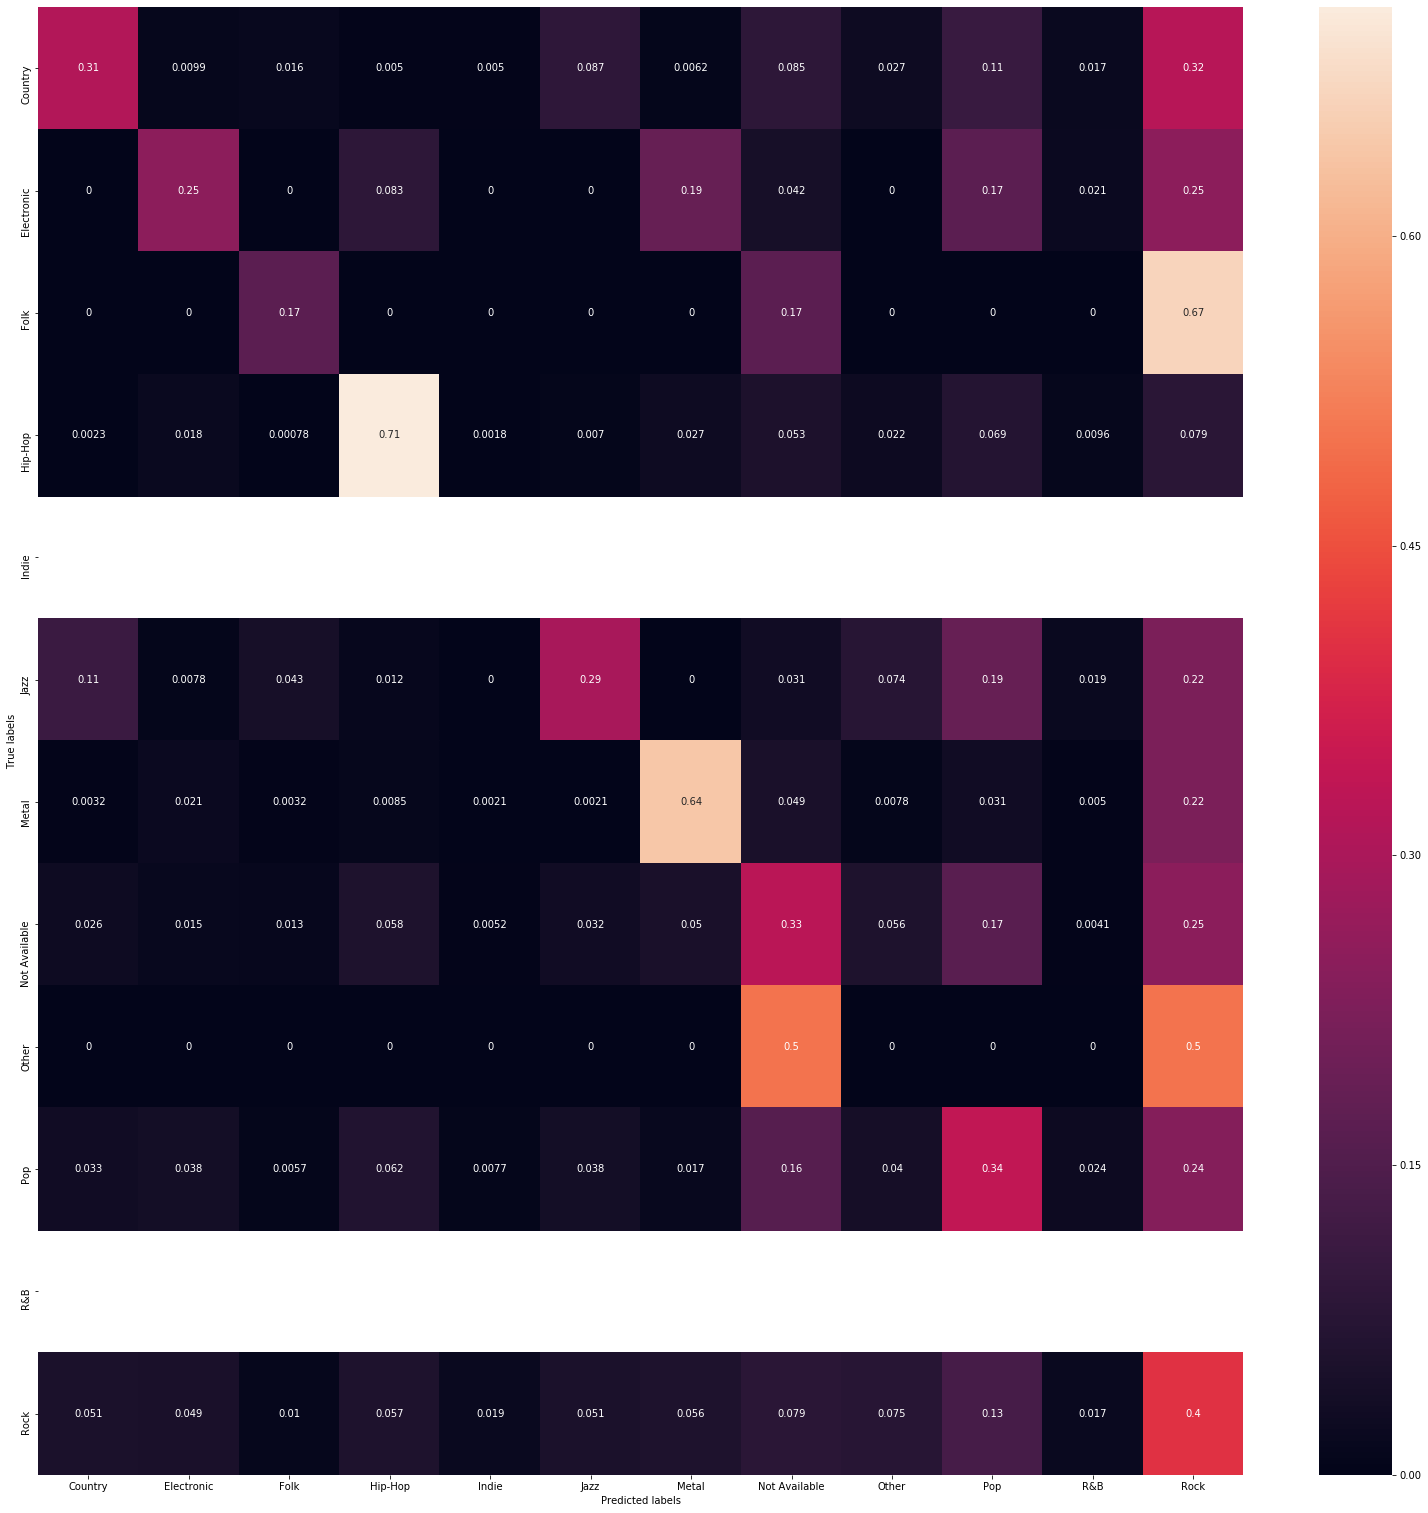

In [35]:
plt.figure(figsize=(27, 27))
cm = confusion_matrix(Y1v_pred, Y1v_test)

cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True) 

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_xticklabels(clf2.classes_)
ax.set_yticklabels(clf2.classes_)

plt.show()

In [36]:
print(classification_report(Y1v_pred, Y1v_test, target_names=clf2.classes_))

/Users/avshalommanevich/opt/anaconda3/envs/py4dp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      Country       0.08      0.31      0.13       808
   Electronic       0.00      0.25      0.01        48
         Folk       0.00      0.17      0.00         6
      Hip-Hop       0.46      0.71      0.56      3838
        Indie       0.00      0.00      0.00         0
         Jazz       0.03      0.29      0.05       258
        Metal       0.37      0.64      0.47      2828
Not Available       0.06      0.33      0.10       969
        Other       0.00      0.00      0.00         2
          Pop       0.14      0.34      0.20      3489
          R&B       0.00      0.00      0.00         0
         Rock       0.90      0.40      0.56     49991

     accuracy                           0.43     62237
    macro avg       0.17      0.29      0.17     62237
 weighted avg       0.78      0.43      0.52     62237



#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

transformed = vectorizer.fit_transform(df['final_words'].apply(lambda l: ' '.join(l)))


In [38]:
df_tfidf = pd.DataFrame(transformed.toarray(), columns = vectorizer.get_feature_names())
print(df_tfidf)

        100s  10s  12th  13th  15s  16s  1st   1x  20s  20th  ...   ð¾  ð¾ð  \
0        0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...  0.0  0.0   
1        0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...  0.0  0.0   
2        0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...  0.0  0.0   
3        0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...  0.0  0.0   
4        0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...  0.0  0.0   
...      ...  ...   ...   ...  ...  ...  ...  ...  ...   ...  ...  ...  ...   
362232   0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...  0.0  0.0   
362233   0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...  0.0  0.0   
362234   0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...  0.0  0.0   
362235   0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...  0.0  0.0   
362236   0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...  0.0  0.0   

        ð¾ñ   øª  øªø  øªù  ø³ù  ø¹ø  ø¹ù  über  
0

In [39]:
df_tfidf.loc[10]


100s    0.0
10s     0.0
12th    0.0
13th    0.0
15s     0.0
       ... 
øªù     0.0
ø³ù     0.0
ø¹ø     0.0
ø¹ù     0.0
über    0.0
Name: 10, Length: 21755, dtype: float64

In [40]:
X1v_tfidf = np.zeros((len(df), EMBEDDING_SIZE))
Y1v_tfidf = df['genre'].values
missing = 0
for i, doc in enumerate(df['final_words']):
    vects = np.zeros((len(doc), EMBEDDING_SIZE))

    for j, word in enumerate(doc):
        if word.lower() in df_tfidf.loc[i]:
            tfidf = df_tfidf.loc[i][word.lower()]
        else:
            missing += 1
            tfidf = 1.0
        vects[j] = tfidf * model.wv[word]
    X1v_tfidf[i] = np.mean(vects, axis=0)


/Users/avshalommanevich/opt/anaconda3/envs/py4dp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/avshalommanevich/opt/anaconda3/envs/py4dp/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [41]:
np.nan_to_num(X1v_tfidf, copy=False)

scaler = MinMaxScaler(copy=False)
scaler.fit_transform(X1v_tfidf)

X1v_tfidf_train = X1v_tfidf[:300000]
Y1v_train = Y1v[:300000]
X1v_tfidf_test = X1v_tfidf[300000:]
Y1v_test = Y1v[300000:]
clf3 = LogisticRegressionCV(cv=5, random_state=0, max_iter=333)
# clf2 = MultinomialNB()
clf3.fit(X1v_tfidf_train, Y1v_train)
Y1v_tfidf_pred = clf3.predict(X1v_tfidf_test)

/Users/avshalommanevich/opt/anaconda3/envs/py4dp/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/avshalommanevich/opt/anaconda3/envs/py4dp/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    ht

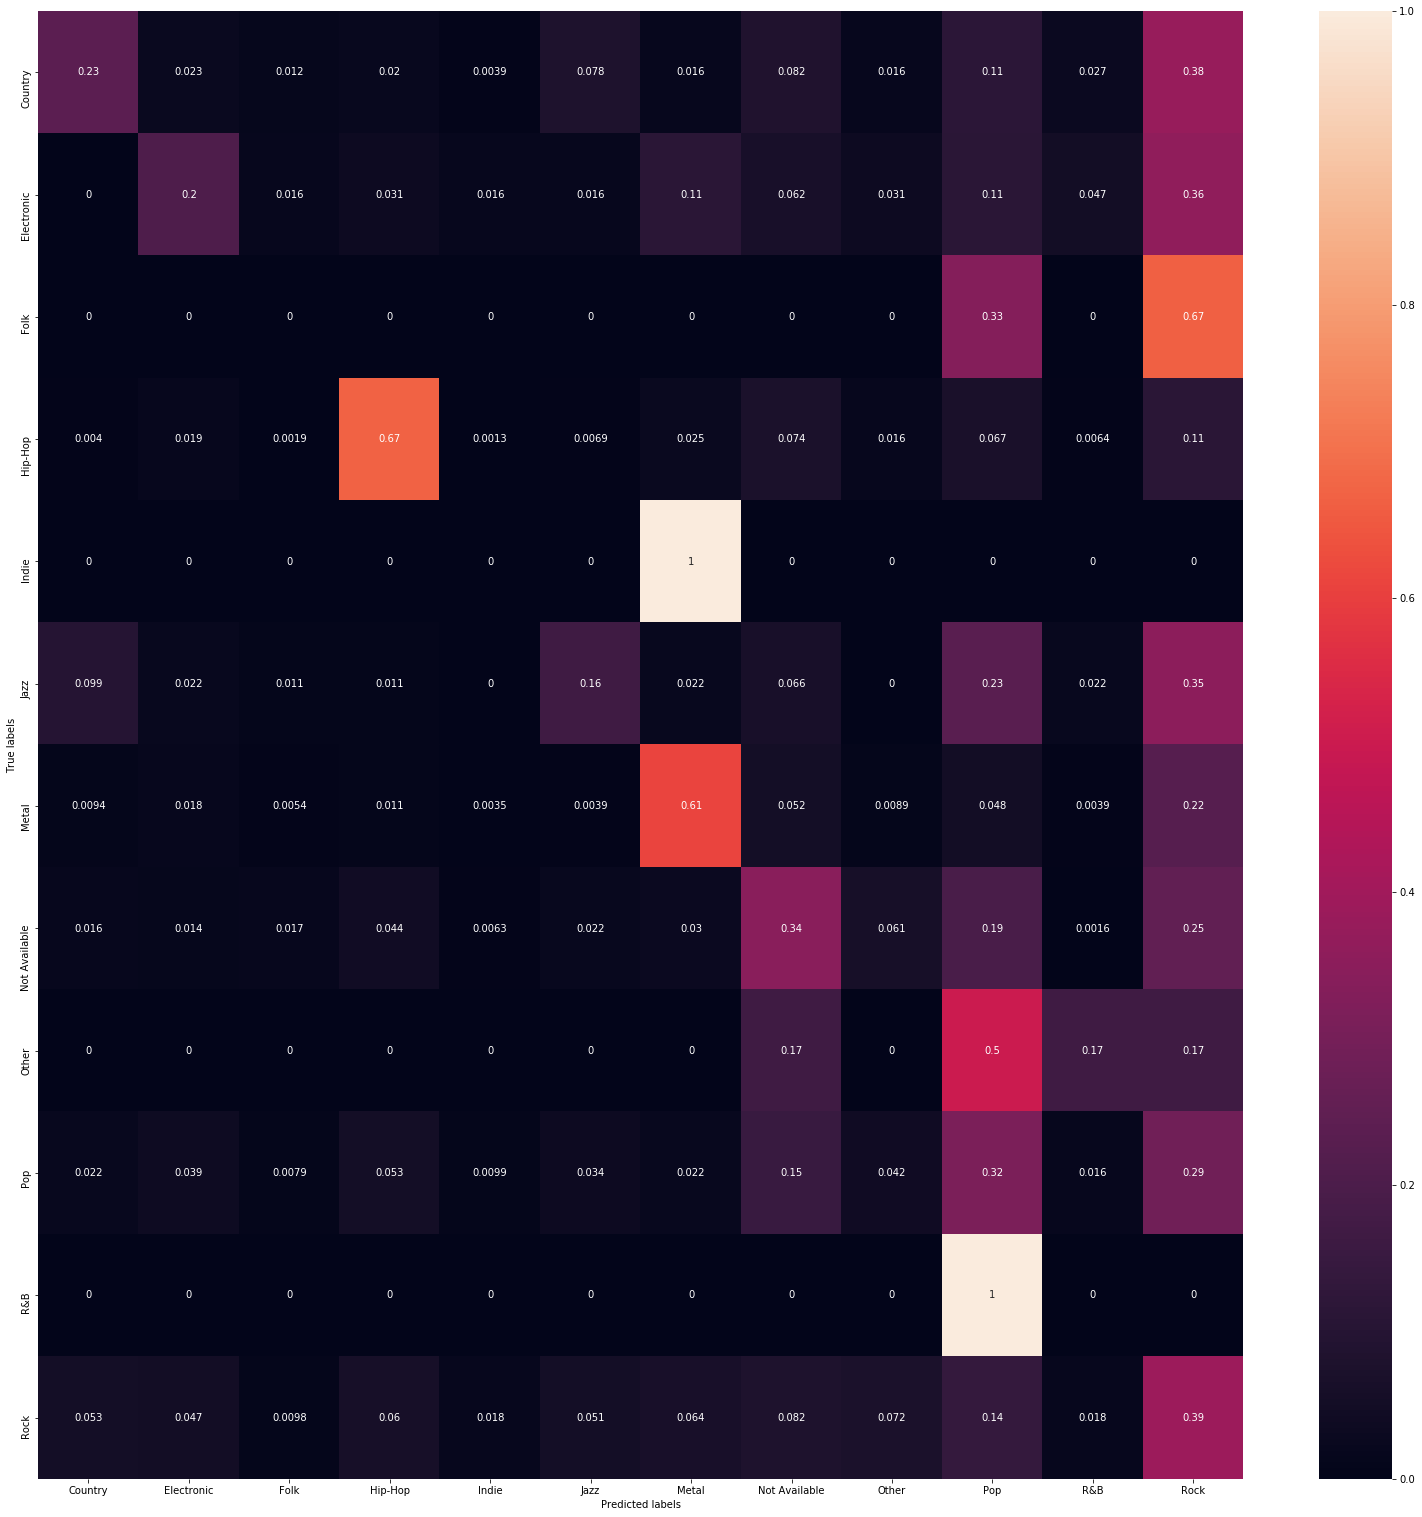

In [42]:
plt.figure(figsize=(27, 27))
cm = confusion_matrix(Y1v_tfidf_pred, Y1v_test)

cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True) 

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_xticklabels(clf3.classes_)
ax.set_yticklabels(clf3.classes_)

plt.show()

In [43]:
print(classification_report(Y1v_tfidf_pred, Y1v_test, target_names=clf3.classes_))


               precision    recall  f1-score   support

      Country       0.02      0.23      0.04       256
   Electronic       0.00      0.20      0.01        64
         Folk       0.00      0.00      0.00         6
      Hip-Hop       0.43      0.67      0.52      3772
        Indie       0.00      0.00      0.00         1
         Jazz       0.01      0.16      0.01        91
        Metal       0.25      0.61      0.36      2026
Not Available       0.04      0.34      0.07       640
        Other       0.00      0.00      0.00         6
          Pop       0.06      0.32      0.10      1515
          R&B       0.00      0.00      0.00         1
         Rock       0.93      0.39      0.55     53859

     accuracy                           0.41     62237
    macro avg       0.15      0.24      0.14     62237
 weighted avg       0.84      0.41      0.52     62237



### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.

In [277]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

class CNN(nn.Module):
    def __init__(self, batch_size, output_size, in_channels, out_channels, kernel_heights, stride, padding, keep_probab, vocab_size, embedding_length, weights):
        super(CNN, self).__init__()
        self.batch_size = batch_size
        self.output_size = output_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_heights = kernel_heights
        self.stride = stride
        self.padding = padding
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.word_embeddings = nn.Embedding(vocab_size + 1, embedding_length, padding_idx=vocab_size)
        self.word_embeddings.weight = nn.Parameter(weights, requires_grad=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, (kernel_heights[0], embedding_length), stride, padding=padding)
        self.conv2 = nn.Conv2d(in_channels, out_channels, (kernel_heights[1], embedding_length), stride, padding=padding)
        self.conv3 = nn.Conv2d(in_channels, out_channels, (kernel_heights[2], embedding_length), stride, padding=padding)
        self.dropout = nn.Dropout(keep_probab)
        self.label = nn.Linear(len(kernel_heights)*out_channels, output_size)

    def conv_block(self, input, conv_layer):
#         print(input.shape)
        conv_out = conv_layer(input)# conv_out.size() = (batch_size, out_channels, dim, 1)
#         print(conv_out.shape)
        activation = F.relu(conv_out.squeeze(3))# activation.size() = (batch_size, out_channels, dim1)
#         print(activation.shape)
        max_out = F.max_pool1d(activation, activation.size()[2]).squeeze(2)# maxpool_out.size() = (batch_size, out_channels)
        return max_out

    def forward(self, input_sentences, batch_size=None):
        input = self.word_embeddings(input_sentences)
        # input.size() = (batch_size, num_seq, embedding_length)
        input = input.unsqueeze(1)
#         print(input.shape)
        # input.size() = (batch_size, 1, num_seq, embedding_length)
    
        max_out1 = self.conv_block(input, self.conv1)
        max_out2 = self.conv_block(input, self.conv2)
        max_out3 = self.conv_block(input, self.conv3)
        all_out = torch.cat((max_out1, max_out2, max_out3), 1)
        # all_out.size() = (batch_size, num_kernels*out_channels)
        fc_in = self.dropout(all_out)
        # fc_in.size()) = (batch_size, num_kernels*out_channels)
        logits = self.label(fc_in)
        return logits

    
batch_size = 32
output_size = 12
in_channels = 1
out_channels = 128
vocab_size = model.wv.vectors.shape[0]
kernel_heights = [3, 4, 5]
stride = 1
padding = (1,0)
keep_probab = 0.5
embedding_length = EMBEDDING_SIZE
weights = np.append(model.wv.vectors, np.zeros(EMBEDDING_SIZE).reshape(-1,100), axis=0)
word_embeddings = torch.from_numpy(weights)
print(weights.shape[0])


        

21797


In [186]:
classes = {f:i for i,f in enumerate(df['genre'].unique())} 
genre_s = df['genre'].apply(lambda x: classes[x])

0         0
1         0
2         0
3         0
4         1
         ..
362232    2
362233    2
362234    5
362235    1
362236    2
Name: genre, Length: 362237, dtype: int64

In [133]:
# df_mat = pd.concat([matrices,df['genre']], axis=1)
def words_to_idxs(words):
    return [model.wv.vocab[word].index for word in words]

words_s = df['final_words'].apply(lambda x: x if len(x) <= 128 else x[:128]).apply(words_to_idxs)


In [216]:
df_final = pd.concat([words_s, genre_s], axis=1)

In [217]:
train_size = int(0.75*len(df_final))
# train_size = 200
df_mat_train = df_final[:train_size]
df_mat_test = df_final[train_size:]

In [275]:
cnn = CNN(batch_size, output_size, in_channels, out_channels, kernel_heights, stride, padding, keep_probab, vocab_size, embedding_length, word_embeddings)
cnn = cnn.float()
cnn = cnn.train()
import time
N_EPOCHS = 10

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    start_time = time.time()

    train_loss = 0
    train_acc = 0
    for i in range(0, len(df_mat_train), batch_size):
        optimizer.zero_grad()
        data = df_mat_train.iloc[i:i + batch_size]
        X = np.full((len(data), 128), VOCAB_LEN)
        for j in range(0, len(data)):
            np_arr = np.array(data.iloc[j].final_words)
            X[j, 0:len(np_arr)] = np_arr
        Y = torch.LongTensor(data.genre.values)
        y_pred = cnn(torch.LongTensor(X))
        loss = criterion(y_pred, Y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
#         print('P',y_pred.argmax(1))
#         print('r',Y)
#         print((y_pred.argmax(1) == Y).sum().item())
        train_acc += (y_pred.argmax(1) == Y).sum().item()
#         print(train_acc)
#     scheduler.step()
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    train_loss /= len(df_mat_train)
    train_acc /= len(df_mat_train)
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    #shuffle train
    df_mat_train = df_mat_train.sample(frac=1).reset_index(drop=True)

        
# VOCAB_LEN = model.wv.vectors.shape[0]
# print(VOCAB_LEN)
# weights = np.append(model.wv.vectors, np.zeros(EMBEDDING_SIZE).reshape(-1,100), axis=0)
# word_embeddings = nn.Embedding(VOCAB_LEN + 1, model.wv.vectors.shape[1], padding_idx=VOCAB_LEN)
# word_embeddings.weight = nn.Parameter(torch.from_numpy(weights), requires_grad=False)
# print(torch.LongTensor([[125,0], [1,2], [1,2]]).shape)
# word_embeddings(torch.LongTensor([[125,VOCAB_LEN], [1,2]]))
# model.wv.index2word[model.wv.vectors.shape[0]]
#torch.Size([32, 100, 128, 3])

# model.wv.vocab['pie'].index

Epoch: 1  | time in 16 minutes, 59 seconds
	Loss: 0.0550(train)	|	Acc: 42.5%(train)
Epoch: 2  | time in 16 minutes, 42 seconds
	Loss: 0.0528(train)	|	Acc: 44.6%(train)
Epoch: 3  | time in 16 minutes, 47 seconds
	Loss: 0.0517(train)	|	Acc: 45.6%(train)
Epoch: 4  | time in 16 minutes, 37 seconds
	Loss: 0.0508(train)	|	Acc: 46.6%(train)
Epoch: 5  | time in 17 minutes, 4 seconds
	Loss: 0.0500(train)	|	Acc: 47.3%(train)
Epoch: 6  | time in 16 minutes, 48 seconds
	Loss: 0.0490(train)	|	Acc: 48.2%(train)
Epoch: 7  | time in 16 minutes, 49 seconds
	Loss: 0.0481(train)	|	Acc: 49.1%(train)
Epoch: 8  | time in 17 minutes, 19 seconds
	Loss: 0.0470(train)	|	Acc: 50.1%(train)
Epoch: 9  | time in 17 minutes, 26 seconds
	Loss: 0.0460(train)	|	Acc: 51.0%(train)
Epoch: 10  | time in 16 minutes, 26 seconds
	Loss: 0.0450(train)	|	Acc: 52.1%(train)


In [276]:
cnn = cnn.eval()
test_acc = 0
for i in range(0, len(df_mat_test)):
        data = df_mat_train.iloc[i:i+1]
#         print(data)
        X = np.full((len(data), 128), VOCAB_LEN)
        for j in range(0, len(data)):
            np_arr = np.array(data.iloc[j].final_words)
            X[j, 0:len(np_arr)] = np_arr
        Y = torch.LongTensor(data.genre.values)
        y_pred = cnn(torch.LongTensor(X))
        test_acc += (y_pred.argmax(1) == Y).sum().item()

test_acc /= len(df_mat_test)

print(f'\tAcc: {test_acc * 100:.1f}%(test)')



	Acc: 56.9%(test)


In [ ]:
cnn = CNN(batch_size, output_size, in_channels, out_channels, kernel_heights, stride, padding, keep_probab, vocab_size, embedding_length, word_embeddings)
cnn = cnn.float()
cnn = cnn.train()
import time
N_EPOCHS = 10

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    start_time = time.time()

    train_loss = 0
    train_acc = 0
    for i in range(0, len(df_mat_train), batch_size):
        optimizer.zero_grad()
        data = df_mat_train.iloc[i:i + batch_size]
        X = np.full((len(data), 128), VOCAB_LEN)
        for j in range(0, len(data)):
            np_arr = np.array(data.iloc[j].final_words)
            X[j, 0:len(np_arr)] = np_arr
        Y = torch.LongTensor(data.genre.values)
        y_pred = cnn(torch.LongTensor(X))
        loss = criterion(y_pred, Y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
#         print('P',y_pred.argmax(1))
#         print('r',Y)
#         print((y_pred.argmax(1) == Y).sum().item())
        train_acc += (y_pred.argmax(1) == Y).sum().item()
#         print(train_acc)
#     scheduler.step()
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    train_loss /= len(df_mat_train)
    train_acc /= len(df_mat_train)
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    #shuffle train
    df_mat_train = df_mat_train.sample(frac=1).reset_index(drop=True)

        
# VOCAB_LEN = model.wv.vectors.shape[0]
# print(VOCAB_LEN)
# weights = np.append(model.wv.vectors, np.zeros(EMBEDDING_SIZE).reshape(-1,100), axis=0)
# word_embeddings = nn.Embedding(VOCAB_LEN + 1, model.wv.vectors.shape[1], padding_idx=VOCAB_LEN)
# word_embeddings.weight = nn.Parameter(torch.from_numpy(weights), requires_grad=False)
# print(torch.LongTensor([[125,0], [1,2], [1,2]]).shape)
# word_embeddings(torch.LongTensor([[125,VOCAB_LEN], [1,2]]))
# model.wv.index2word[model.wv.vectors.shape[0]]
#torch.Size([32, 100, 128, 3])

# model.wv.vocab['pie'].index